# Here I add the materials science specific functions

Terminology:
- SIC: symmetry independent configuration
- SEC: symmetry equivalent configuration

Work in progress:
- DFT calculations
    - graphene H clusters of different sizes to check the band gap


- [Build the reference 2x2 graphene supercell](#build_structure)
- [Symmetry analysis](#symmetry)
- [Exhaustive search](#es)
- [Non-periodic boudnary conditions](#no_pbc)
- [Build the test/train set](#test_train)
- [Periodic boudnary conditions](#pbc)

In [652]:
from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
import copy
import numpy as np
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
import itertools
from scipy import constants
import math
import shutil as sh

import sys
sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')
from crystal_io import *
from convert import *

#from CRYSTALpytools.convert import *
#from CRYSTALpytools.crystal_io import *

import matplotlib.pyplot as plt

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]
plt.style.use('tableau-colorblind10')
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

# <a id='build_structure'>Build the reference 2x2 graphene supercell</a>

Build a supercell with pymatgen

#### PBC

In [420]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])


#### No PBC

In [469]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell = Molecule(graphene_scell.atomic_numbers,
                           graphene_scell.cart_coords[ordering])


# Build the reference 3x3 graphene supercell

Build a supercell with pymatgen

#### PBC

In [443]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 3
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [2,11,1,5,10,14,0,4,8,9,13,17,3,7,12,16,6,15]
graphene_scell_3 = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])


In [445]:
vview(graphene_scell_3)

#### No PBC

In [447]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 3
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [2,11,1,5,10,14,0,4,8,9,13,17,3,7,12,16,6,15]
graphene_scell_no_pbc_3 = Molecule(graphene_scell.atomic_numbers,
                           graphene_scell.cart_coords[ordering])


## <a id='mapping'>Direct mapping</a>

In [465]:
rad_s_to_eV = 6.5821e-16
C = 5.42e-24
R = (C*rad_s_to_eV)**(1/6)
R

3.908954606304587e-07

In [466]:
(C/0.019894 * rad_s_to_eV)**(1/6)

7.509429449914071e-07

## <a id='symmetry'>Symmetry analysis</a>

In [39]:
def get_all_configurations_pbc(structure):
    
    """
    Find the list of equivalent sites according to the 
    symmetry of the system for structures with periodic 
    boundary conditions.

    Args:
        structure (pymatgen Structure): pymatgen Structure object.
        
    Returns:
        atom_indices (numpy array): N_sites x N_symmops array of 
                                    equivalent structures.
    """


    symmops = SpacegroupAnalyzer(structure).get_symmetry_operations()
    
    #print(symmop)
    coordinates = np.array(structure.frac_coords)
    n_symmops = len(symmops)
    atom_numbers = np.array(structure.atomic_numbers)
    lattice = structure.lattice.matrix
    
    original_structure = copy.deepcopy(structure)
            
    atom_indices = []
    structures = []
    for i,symmop in enumerate(symmops[0:10]):
        atom_indices_tmp = []
        coordinates_new = []
        for site in coordinates:
            coordinates_new.append(symmop.operate(site))

        structure_tmp = Structure(lattice,atom_numbers,coordinates_new,coords_are_cartesian=False,to_unit_cell=False)
        vview(structure_tmp)
        for k,coord in enumerate(original_structure.frac_coords):
            structure_tmp.append(original_structure.atomic_numbers[k],coord,coords_are_cartesian=False,validate_proximity=False)
        
        for m in range(len(atom_numbers)):
            index = len(atom_numbers)+m
            for n in range(len(atom_numbers)):
                #print(m,n,structure_tmp.frac_coords[n]-structure_tmp.frac_coords[index],structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]))
                if structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]):
                    atom_indices_tmp.append(n)
                    break
        atom_indices.append(atom_indices_tmp)

    return atom_indices
#atom_indices = get_all_configurations_pbc(graphene_scell)

In [467]:
def get_all_configurations_no_pbc(structure):
    
    """
    Find the list of equivalent sites according to the 
    symmetry of the system for structures without periodic 
    boundary conditions.

    Args:
        structure (pymatgen Molecule): pymatgen Molecule object.
        
    Returns:
        atom_indices (numpy array): N_sites x N_symmops array of 
                                    equivalent structures.
    """
    
    symmops = PointGroupAnalyzer(structure).get_symmetry_operations()
    structure.translate_sites(np.arange(structure.num_sites),-structure.center_of_mass)

    coordinates = np.array(structure.cart_coords)
    n_symmops = len(symmops)
    atom_numbers = np.array(structure.atomic_numbers)
    
    original_structure = copy.deepcopy(structure)
            
    atom_indices = []
    structures = []
    for i,symmop in enumerate(symmops):
        atom_indices_tmp = []
        coordinates_new = []
        for site in coordinates:
            coordinates_new.append(symmop.operate(site))

        structure_tmp = Molecule(atom_numbers,coordinates_new)
        structure_tmp.translate_sites(np.arange(structure_tmp.num_sites),-structure_tmp.center_of_mass)

        for k,coord in enumerate(original_structure.cart_coords):
            structure_tmp.append(original_structure.atomic_numbers[k],coord,validate_proximity=False)
        #print(np.unique(np.round(structure_tmp.cart_coords,4),axis=0))
        #vview(structure_tmp)
        for m in range(len(atom_numbers)):
            index = len(atom_numbers)+m
            for n in range(len(atom_numbers)):
                #print(m,n,structure_tmp.frac_coords[n]-structure_tmp.frac_coords[index],structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]))
                #if structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]):
                if np.all(np.round(structure_tmp.cart_coords[n],4) == np.round(structure_tmp.cart_coords[index],4)):
                    atom_indices_tmp.append(n)
                    break
        atom_indices.append(atom_indices_tmp)

    return atom_indices
atom_indices = get_all_configurations_no_pbc(graphene_scell_no_pbc_3)

In [451]:
np.savetxt('data/atom_indices_18_no_pbc.csv', atom_indices, delimiter=',')


TypeError: savetxt() got an unexpected keyword argument 'dtype'

In [41]:
def build_symmetry_equivalent_configurations(atom_indices,N_index):
    
    """
    Given a list of atom_indices and position of the dopants generate
    all the equivalent structures.

    Args:
        atom_indices (numpy array): N_sites x N_symmops array of 
                                    equivalent structures obtained from
                                    get_all_configurations_no_pbc() or
                                    get_all_configurations_pbc().
        N_index (numpy array): N_dopants array of position of dopant atoms
                               in the structure
        
    Returns:
        unique_configurations (numpy array): binary array where x_i == 1 
                                             means there is a dopant atom in 
                                             position i
    """
    if len(N_index) == 0:

        return np.tile(np.zeros(len(atom_indices[0]),dtype='int'), (len(atom_indices), 1))
    configurations = atom_indices == -1
    for index in N_index:
        configurations += atom_indices == index
    configurations = configurations.astype(int)

    unique_configurations,unique_configurations_index = np.unique(configurations,axis=0,return_index=True)
    
    return unique_configurations


In [209]:
atom_indices_96

[[68,
  73,
  62,
  66,
  67,
  61,
  65,
  71,
  72,
  60,
  64,
  70,
  75,
  63,
  69,
  74,
  113,
  117,
  105,
  108,
  112,
  104,
  107,
  111,
  116,
  106,
  110,
  115,
  119,
  109,
  114,
  118,
  77,
  80,
  84,
  76,
  79,
  83,
  87,
  78,
  82,
  86,
  81,
  85,
  89,
  92,
  96,
  97,
  88,
  91,
  95,
  100,
  101,
  90,
  94,
  99,
  103,
  93,
  98,
  102,
  20,
  24,
  28,
  19,
  23,
  27,
  31,
  17,
  18,
  22,
  26,
  30,
  16,
  21,
  25,
  29,
  34,
  38,
  33,
  37,
  41,
  32,
  36,
  40,
  43,
  35,
  39,
  42,
  4,
  8,
  3,
  7,
  12,
  2,
  6,
  11,
  15,
  1,
  5,
  10,
  14,
  0,
  9,
  13,
  47,
  52,
  46,
  51,
  56,
  45,
  50,
  55,
  59,
  44,
  49,
  54,
  58,
  48,
  53,
  57],
 [17,
  16,
  20,
  19,
  18,
  24,
  23,
  22,
  21,
  28,
  27,
  26,
  25,
  31,
  30,
  29,
  1,
  0,
  4,
  3,
  2,
  8,
  7,
  6,
  5,
  12,
  11,
  10,
  9,
  15,
  14,
  13,
  34,
  33,
  32,
  38,
  37,
  36,
  35,
  41,
  40,
  39,
  43,
  42,
  47,
  46,
  4

In [609]:
def find_sic(configurations,atom_indices, energies=None, sort=True):
    
    """
    Find symmetry-inequivalent configurations (SIC) and return their corresponding unique energies.

    This function takes a list of binary configurations and their associated energies,
    as well as atom indices, and returns the unique SIC, unique energies, and the multiplicity
    of each unique configuration.

    Parameters:
    - configurations (numpy array 2D): A list of binary configurations.
    - energies (numpy array 1D): A list of energies (one per configuration).
    - atom_indices (numpy array 1D): Atom indices returned by get_all_configurations_no_pbc or get_all_configurations_pbc.

    Returns:
    - config_unique (List[List[int]]): A list of unique symmetry-inequivalent configurations.
    - unique_energies (List[float]): A list of unique energies corresponding to config_unique.
    - multiplicity (List[int]): A list of multiplicity values for each unique configuration.
    """
    
    config_unique = []
    multiplicity = []
    keep_energy = [] 
    for i,config in enumerate(configurations):
        
        sites = np.where(config == 1)[0] 
        sec = build_symmetry_equivalent_configurations(atom_indices,sites)
        sic = sec[0]
        is_in_config_unique = any(np.array_equal(sic, existing_sic) for existing_sic in config_unique)
        
        if not is_in_config_unique:  

            config_unique.append(sic)

            multiplicity.append(len(sec))
            if energies is not None:
                keep_energy.append(i)
    if sort == True:
        n_ones = np.sum(config_unique,axis=1)
        config_unique = (np.array(config_unique)[np.argsort(n_ones)]).tolist()
        
    
        if energies is not None:
            unique_energies = np.array(energies)[keep_energy]
            unique_energies = (unique_energies[np.argsort(n_ones)]).tolist()
        
            return config_unique, unique_energies, multiplicity
        else:
            return config_unique, multiplicity
    else:
        if energies is not None:
            return config_unique, unique_energies, multiplicity
        else:
            return config_unique, multiplicity
    

Example on how to use the above. 

In this case the energies are random numbers, but in a real scenario they would be the same for SIC.

In [607]:
#Generate all configurations (you would use yours)
configurations = np.array(list(itertools.product([0, 1], repeat=graphene_scell.num_sites)))
#Generate random energies (you would use yours)
energies = np.random.rand(len(configurations))

atom_indices = get_all_configurations_no_pbc(graphene_scell)

config_unique, unique_energies, multiplicity = find_sic(configurations,atom_indices,energies)

## Sort by number of 1s

In [496]:
n_ones = np.sum(config_unique,axis=1)
config_unique_sorted = np.array(config_unique)[np.argsort(n_ones)]
n_ones[:-1]-n_ones[1:]
np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]

array([ 0,  3, 14, 31, 55, 72, 83, 86])

## Divide J1 and J2 contributions

In [432]:
def get_partition_function(energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.):
    """
    Calculate the partition function and probabilities for different energy levels.
    
    Args:
        energy (np.ndarray): Array of energy levels.
        multiplicity (np.ndarray): Array of corresponding multiplicities.
        T (float, optional): Temperature in Kelvin. Default is 298.15 K.
        return_pi (bool, optional): Flag to return probabilities. Default is True.
        N_N (float, optional): Number of N particles. Default is 0.
        N_potential (float, optional): Potential for N particles. Default is 0.

    Returns:
        tuple or float: If return_pi is True, returns a tuple containing partition function and probabilities.
                        Otherwise, returns the partition function.
    """
    k_b = 8.617333262145e-05  # Boltzmann constant in eV/K
    
    energy = np.array(energy)
    multiplicity = np.array(multiplicity)
    p_i = multiplicity * np.exp((-energy + (N_N * N_potential)) / (k_b * T))
    pf = np.sum(p_i)
    
    p_i /= pf
    
    if return_pi:
        return pf, p_i
    else:
        return pf

## <a id='es'>Exhaustive search</a>

In [686]:
def plot_E_p_QUBO(structure,J1,J2nn,J2nnn,mu=0.0):
    
    #mu is defined in terms of the fraction of J1, so the term that is added to the J1 terms is J1*mu

    structure = Molecule(graphene_scell.atomic_numbers,graphene_scell.cart_coords)

    configurations = np.array(list(itertools.product([0, 1], repeat=structure.num_sites)))
    atom_indices = get_all_configurations_no_pbc(graphene_scell)

    config_unique, multiplicity = find_sic(configurations,atom_indices,sort=True)

    Q_structure = build_adjacency_matrix(structure,max_neigh=2)

    nn = np.where(Q_structure==1.)
    Q_structure[nn] = J2nn

    nnn = np.where(Q_structure==2.)
    Q_structure[nnn] = J2nnn
    
    diagonal_term = J1+J1*mu
    np.fill_diagonal(Q_structure,diagonal_term)

    E_structure = []
    E_structure_J1 = []
    E_structure_J2 = []


    for config in config_unique:
        E_structure.append(classical_energy(config,Q_structure))
        E_structure_J1.append(J1_energy(config,Q_structure))
        E_structure_J2.append(J2_energy(config,Q_structure))
    E_structure

    E_structure = np.array(E_structure)

    # Calculate the minimum and maximum values
    min_val = np.min(E_structure)
    max_val = np.max(E_structure)

    n_ones = np.sum(config_unique,axis=1)
    #config_unique_sorted = np.array(config_unique)[np.argsort(n_ones)]
    n_ones[:-1]-n_ones[1:]
    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    # Normalize the dataset
    E_structure_normalised = (E_structure - min_val) / (max_val - min_val)

    Z, pi = get_partition_function(E_structure, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    #print(np.argmax(pi),np.argsort(E_structure))

    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('J1={}, J2={}, J3={}, mu={}, diag_term={}'.format(
                                                            J1,J2nn,J2nnn,J1*mu,round(diagonal_term,4)),fontsize=16)
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
        axs[0].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
        axs[1].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    
    if diagonal_term >= 0:
        axs[0].bar(np.arange(len(E_structure)),E_structure_J1,width=0.5,label='J1')
        axs[0].bar(np.arange(len(E_structure)),E_structure_J2,width=0.5, bottom=E_structure_J1,label='J2')
    else:
        axs[0].bar(np.arange(len(E_structure)),E_structure_J1,width=0.5,label='J1')
        axs[0].bar(np.arange(len(E_structure)),E_structure_J2,width=0.5,label='J2')
        axs[0].bar(np.arange(len(E_structure)),E_structure,width=0.5,label='E tot' )
        
    axs[0].set_xlabel('SIC index',fontsize=14)
    axs[0].set_ylabel('Energy',fontsize=14)
    axs[0].legend()

    axs[1].bar(np.arange(len(E_structure)),pi)
    axs[1].set_xlabel('SIC index',fontsize=14)
    axs[1].set_ylabel('Probability',fontsize=14)
    plt.show()

potential =-400%


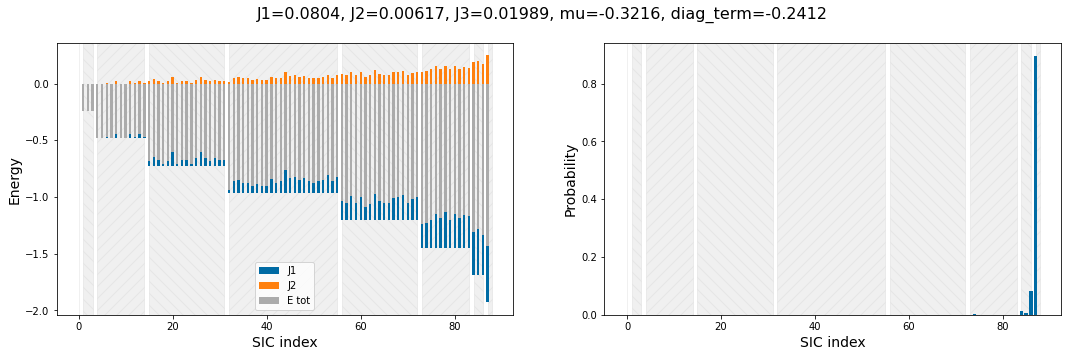

potential =-390%


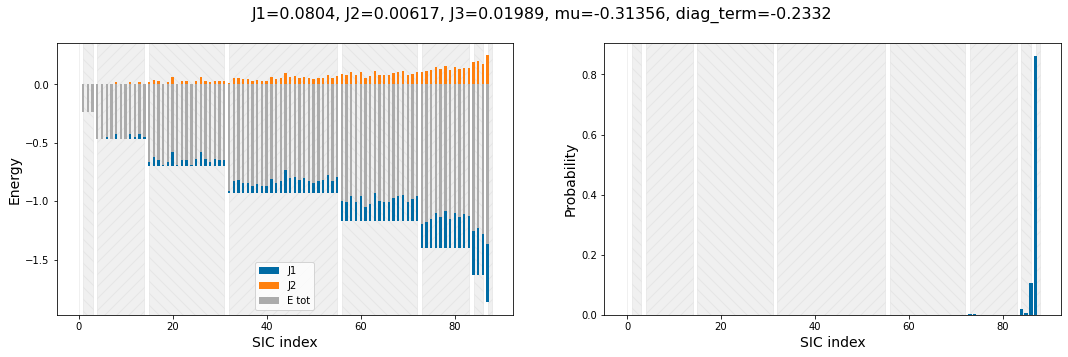

potential =-380%


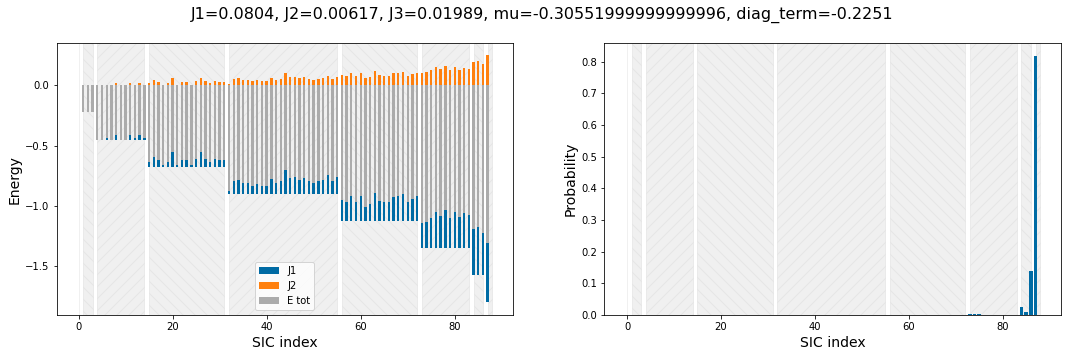

potential =-370%


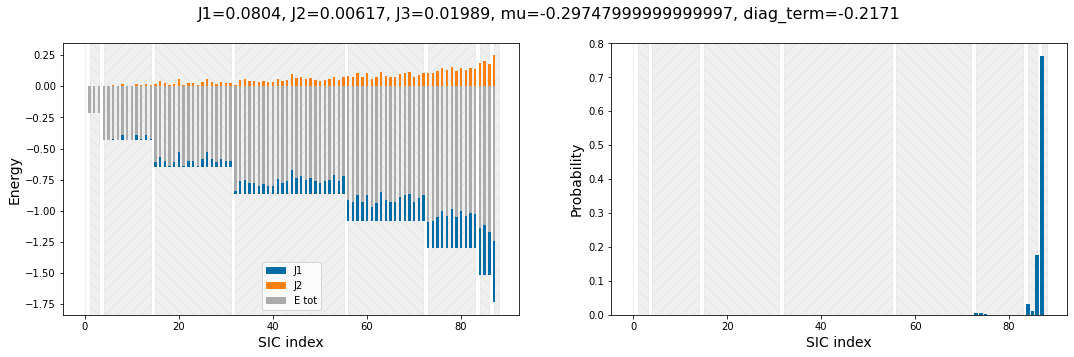

potential =-360%


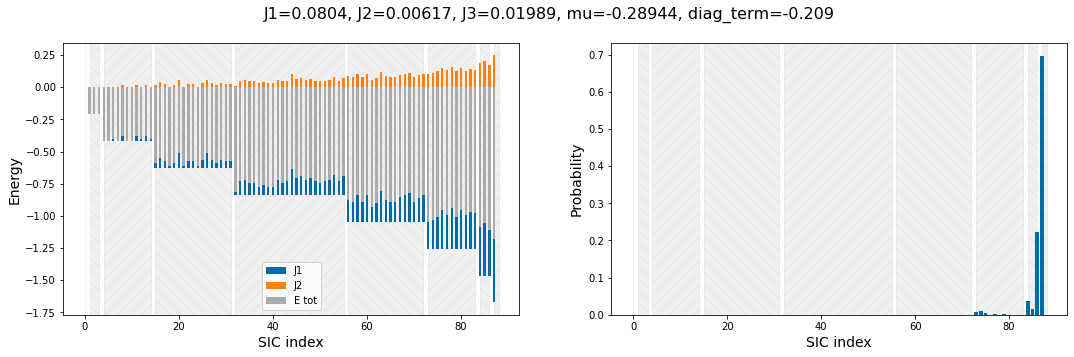

potential =-350%


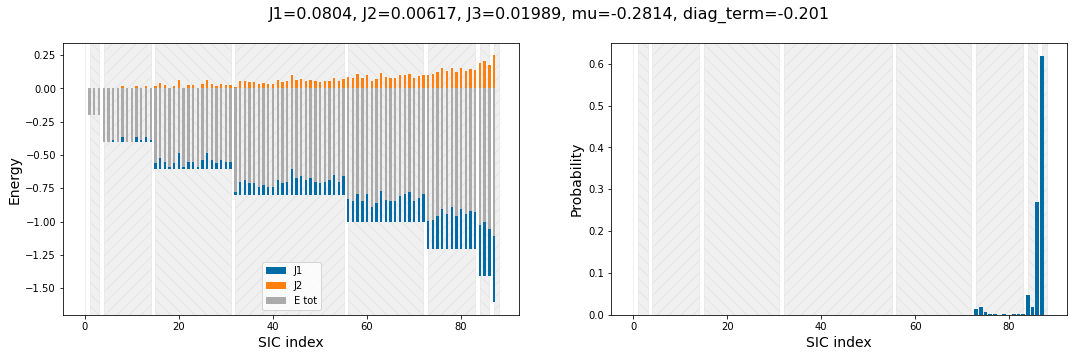

potential =-340%


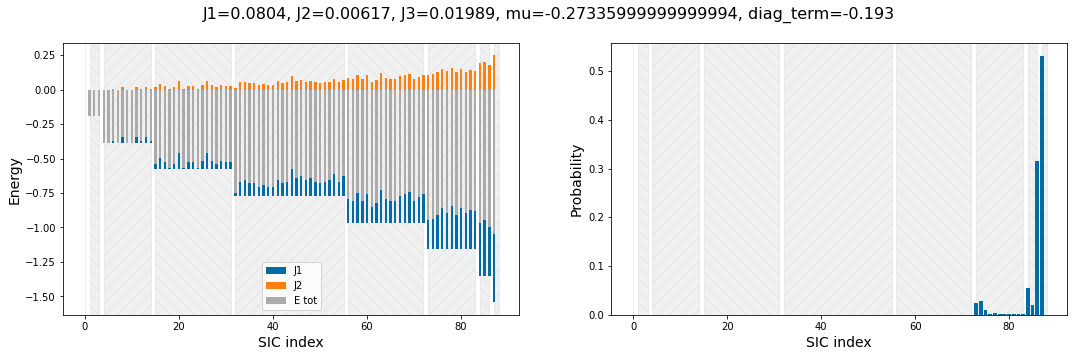

potential =-330%


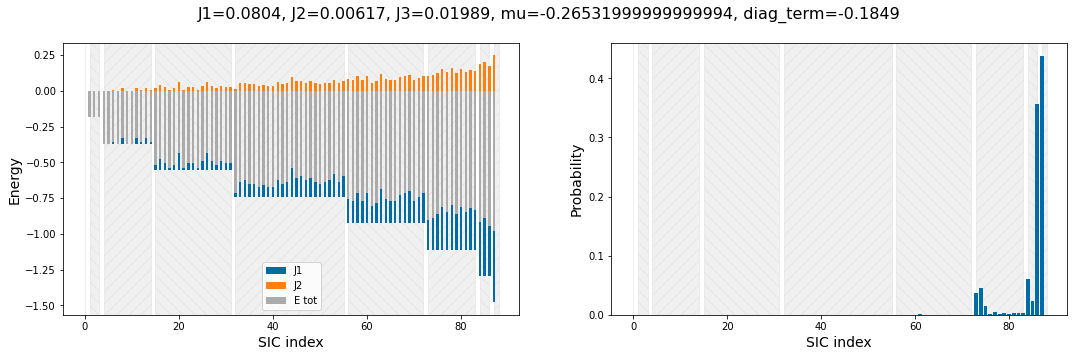

potential =-320%


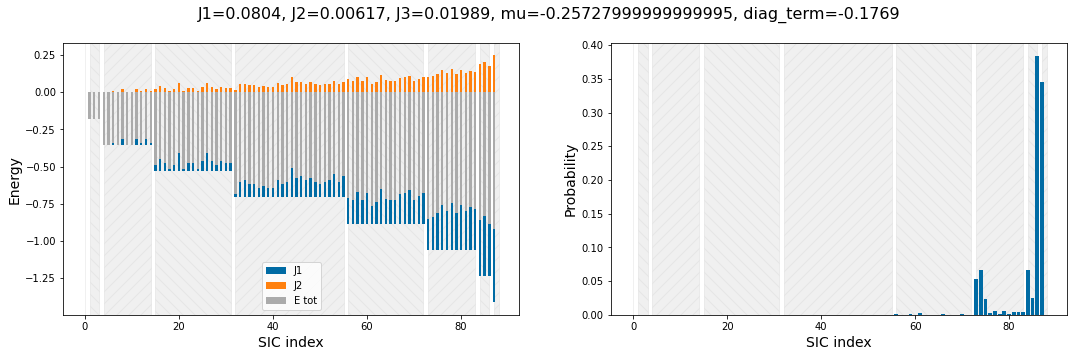

potential =-310%


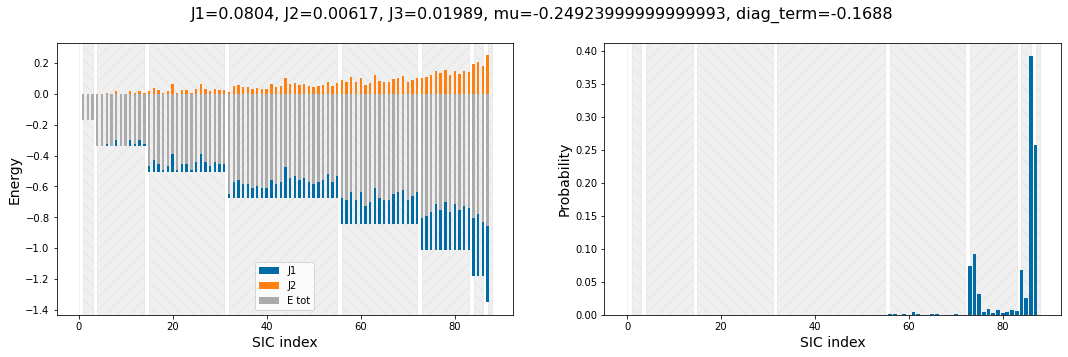

potential =-300%


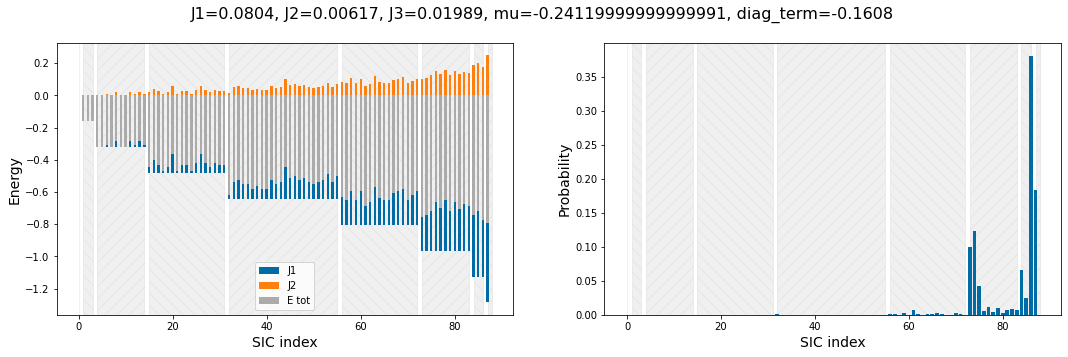

potential =-290%


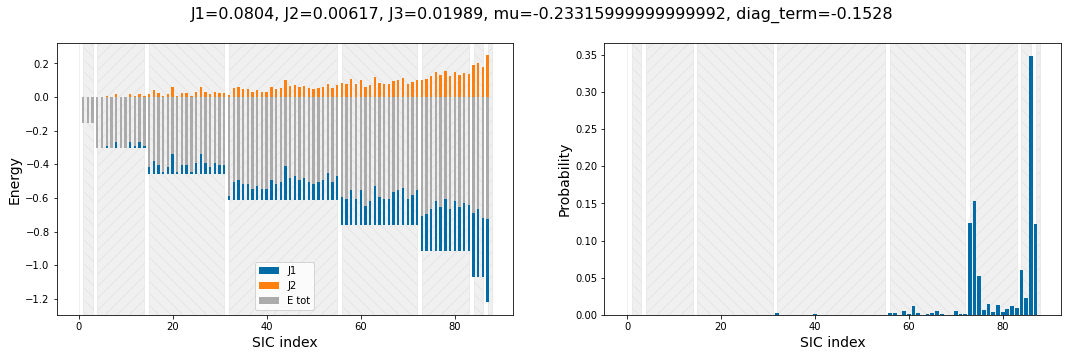

potential =-280%


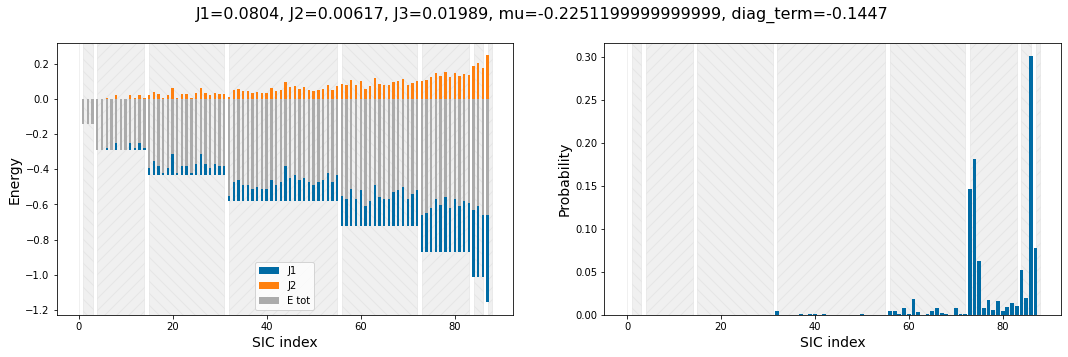

potential =-270%


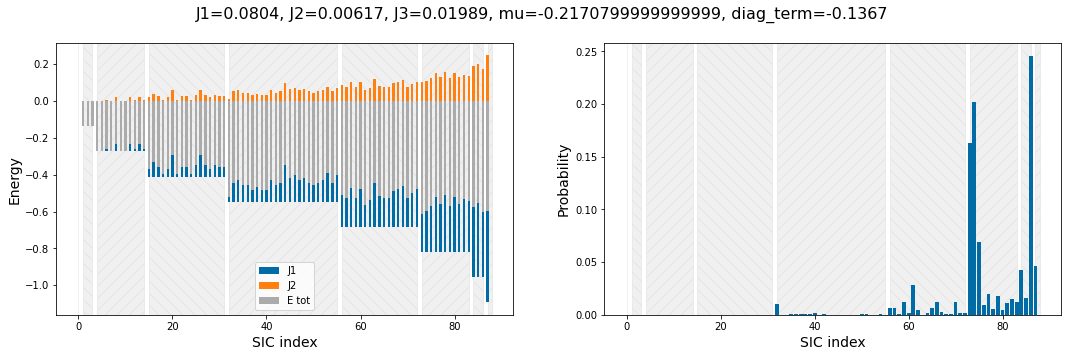

potential =-260%


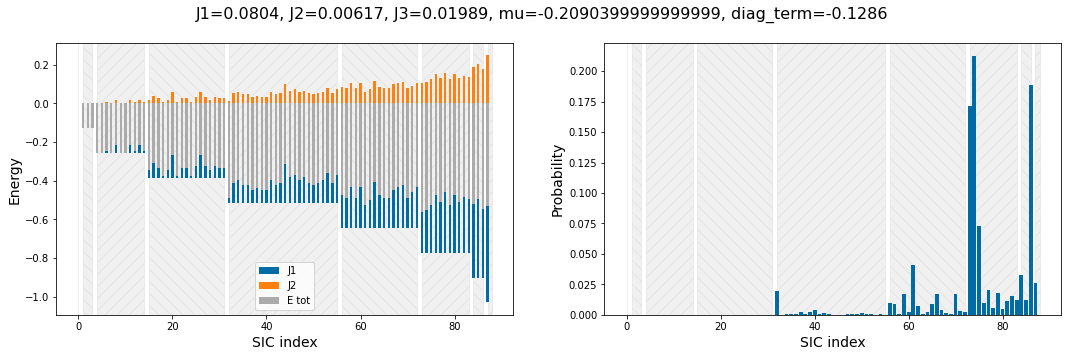

potential =-250%


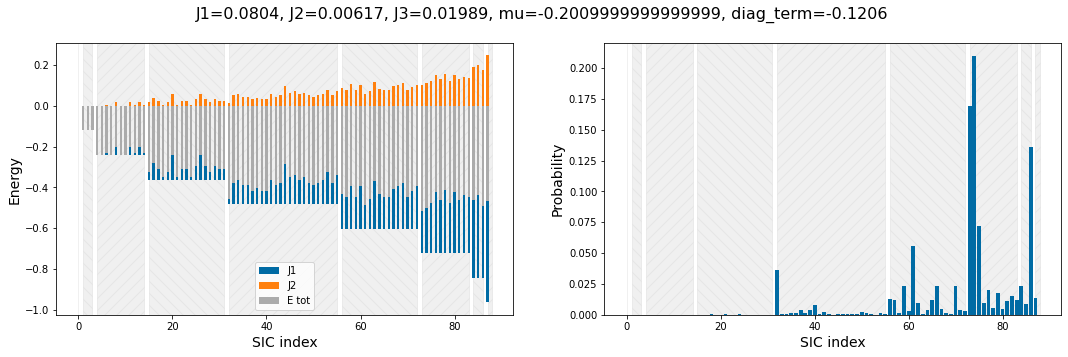

potential =-240%


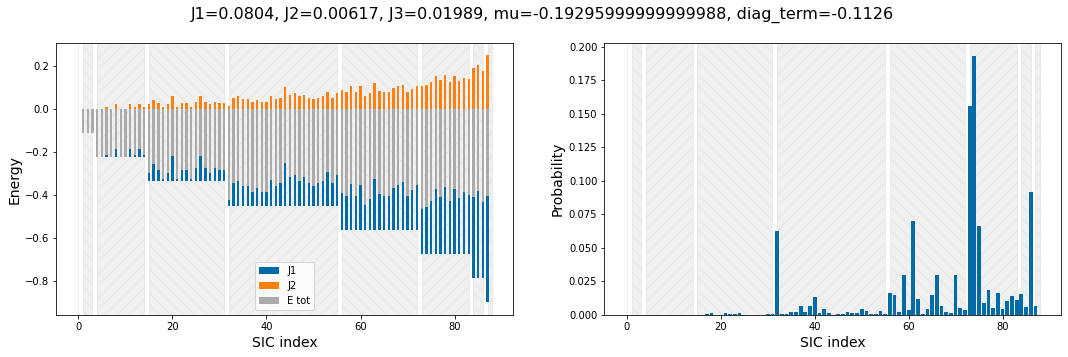

potential =-230%


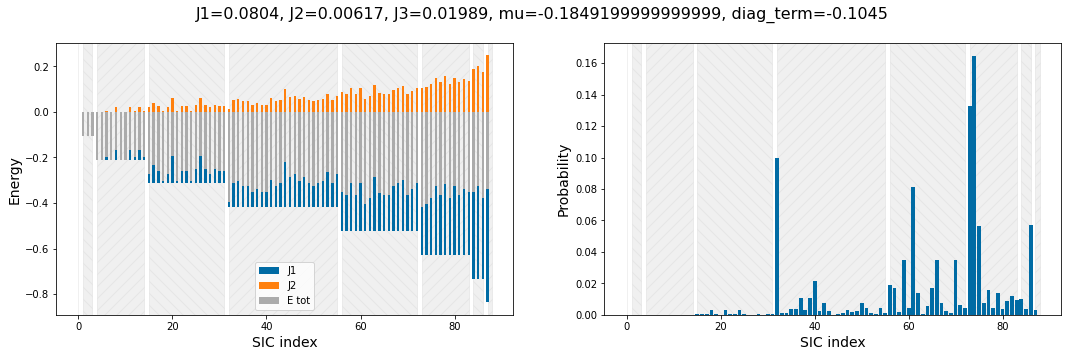

potential =-220%


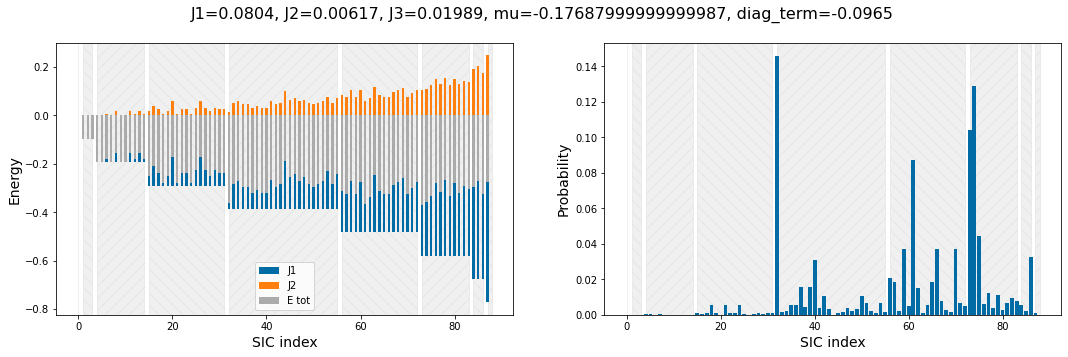

potential =-210%


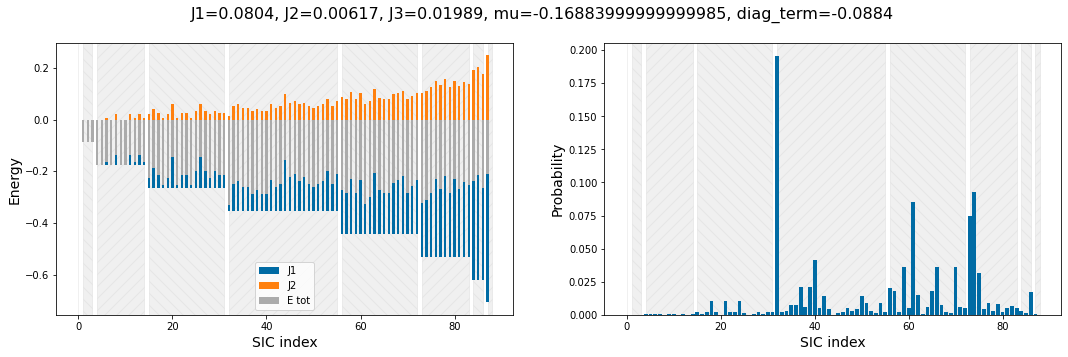

potential =-200%


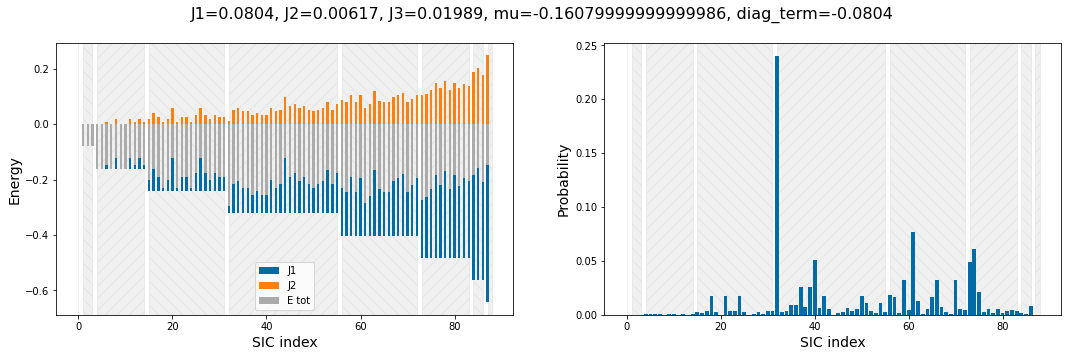

potential =-190%


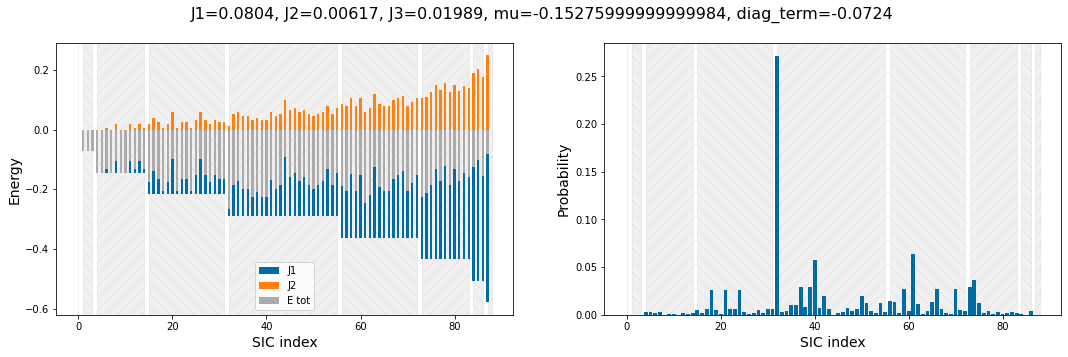

potential =-180%


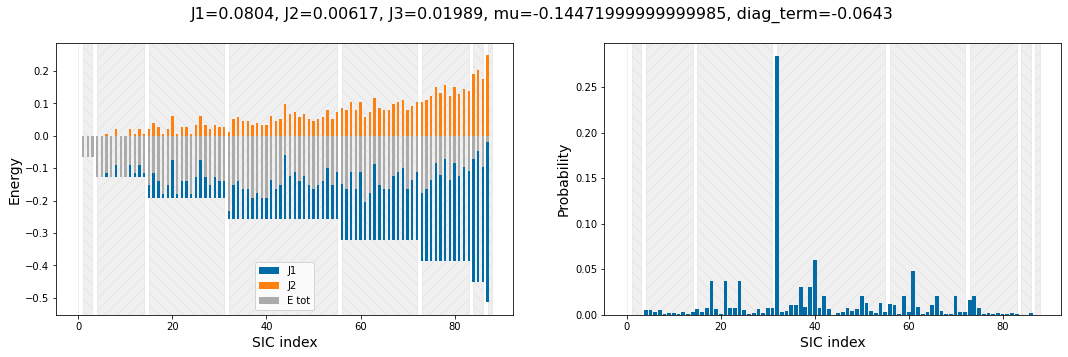

potential =-170%


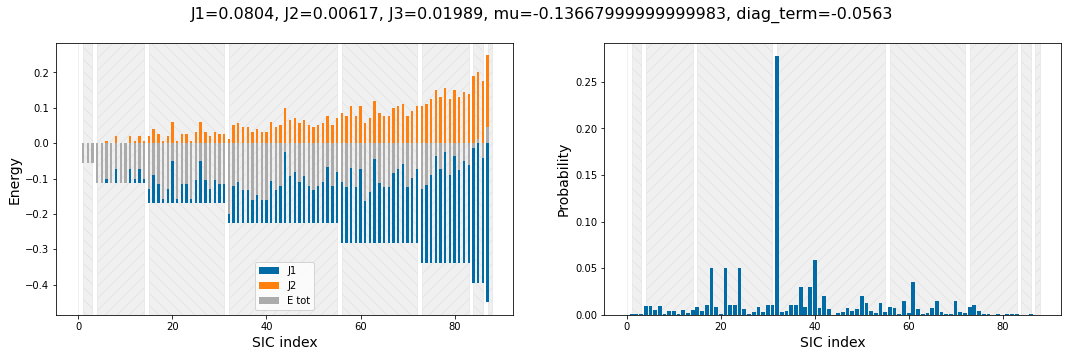

potential =-160%


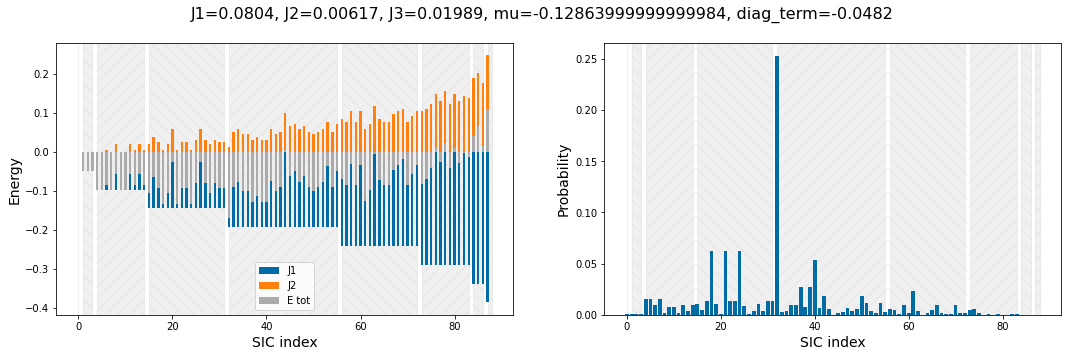

potential =-150%


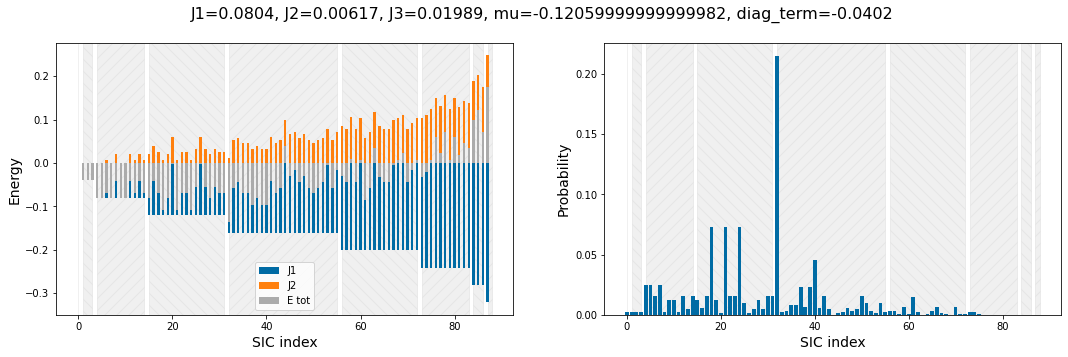

potential =-140%


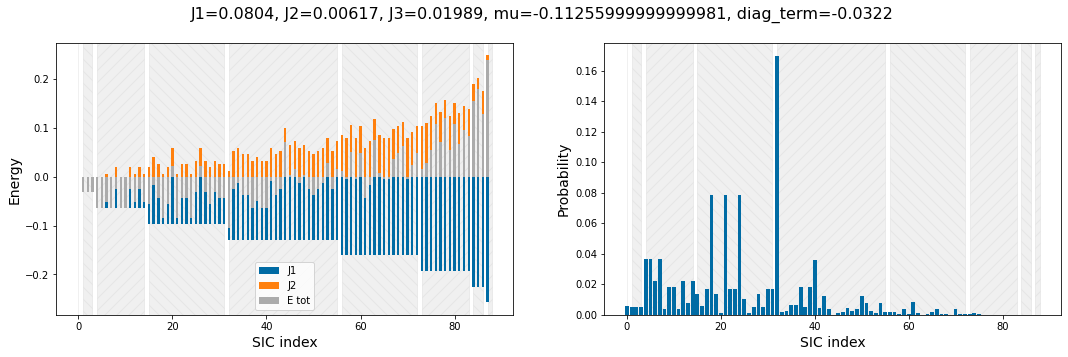

potential =-130%


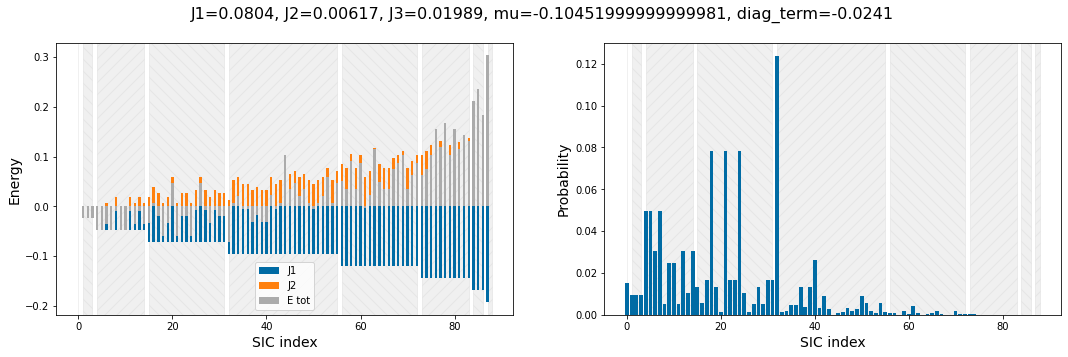

potential =-120%


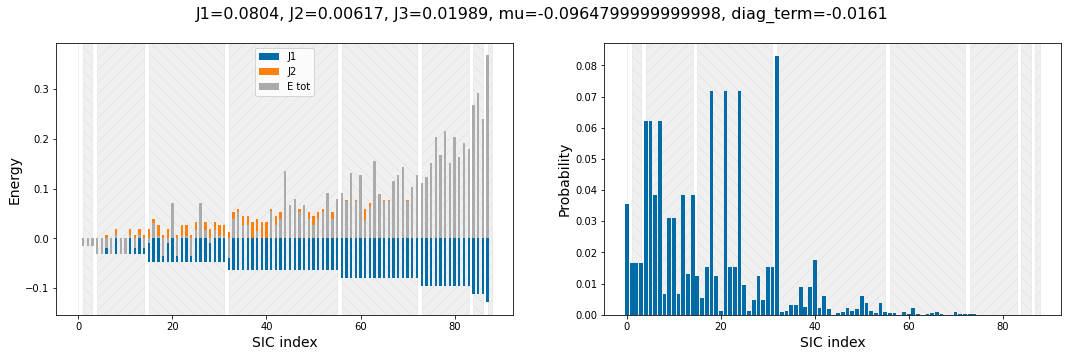

potential =-110%


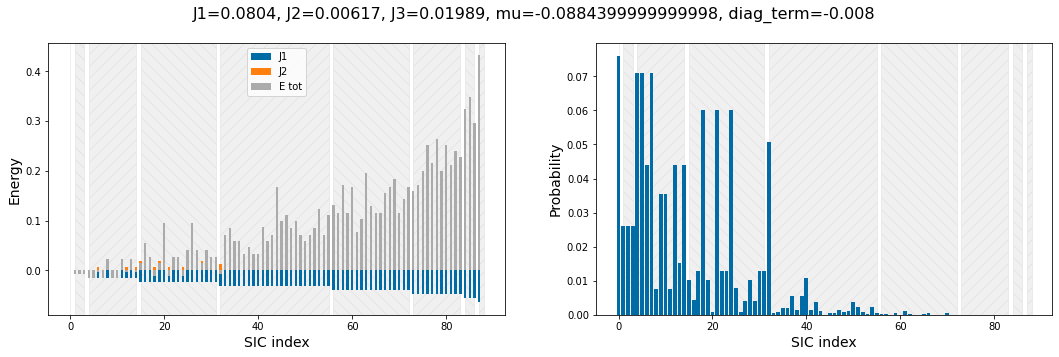

potential =-100%


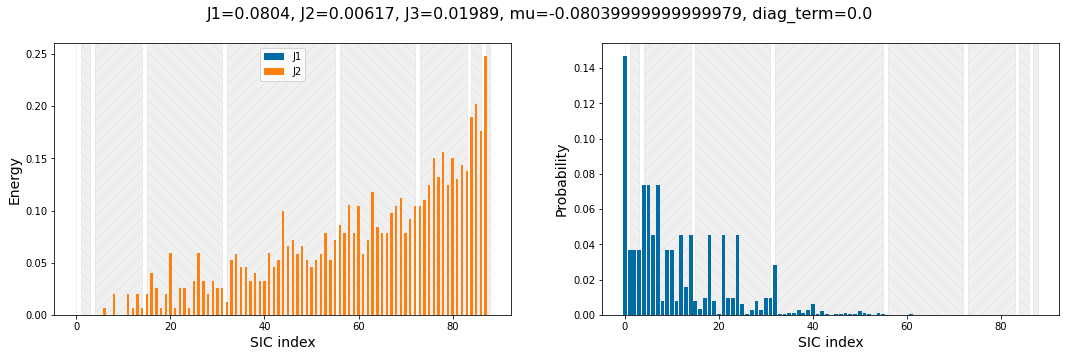

potential =-90%


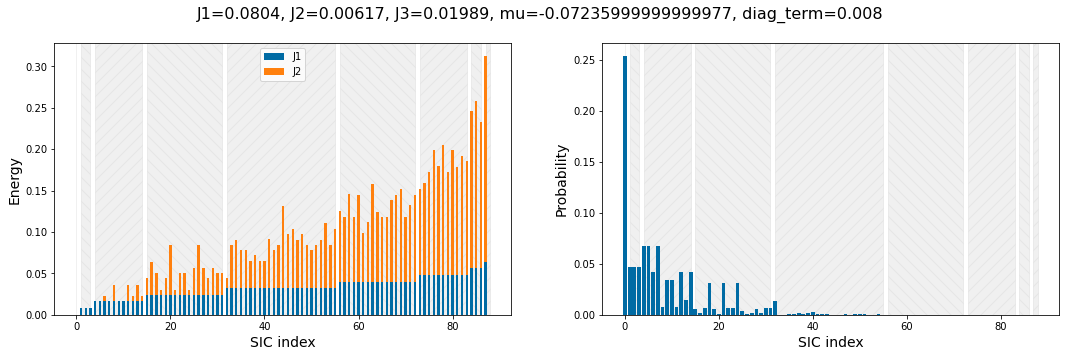

potential =-80%


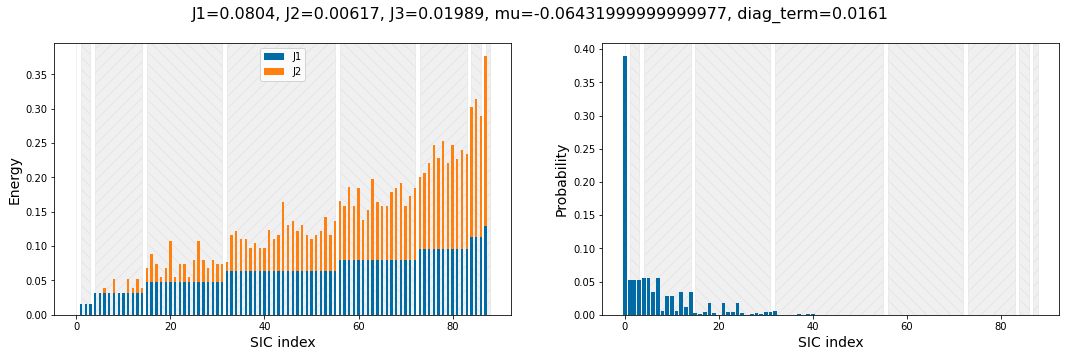

potential =-70%


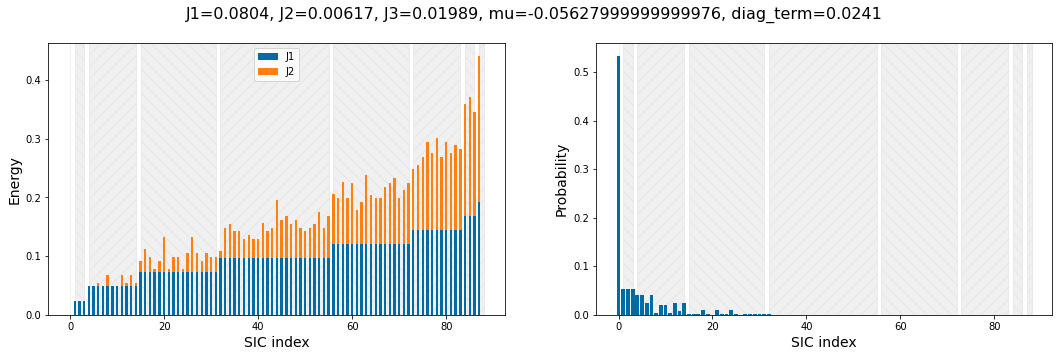

potential =-60%


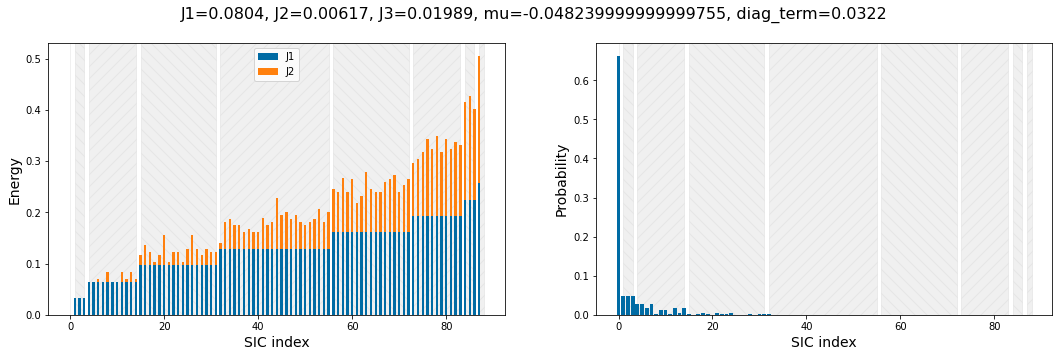

potential =-50%


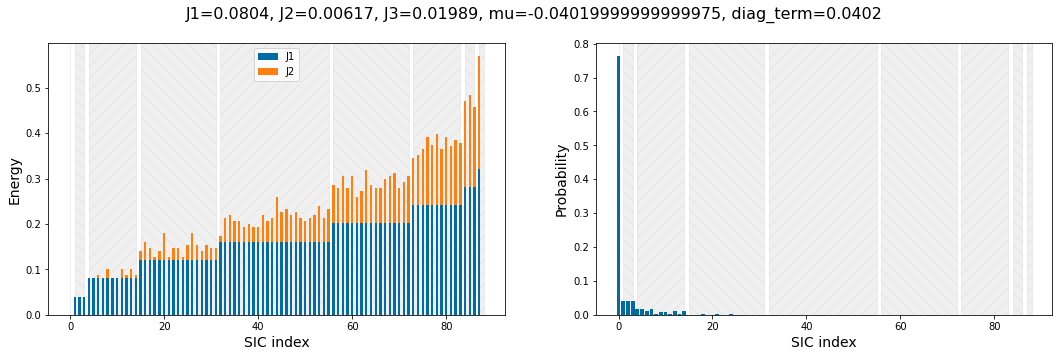

potential =-40%


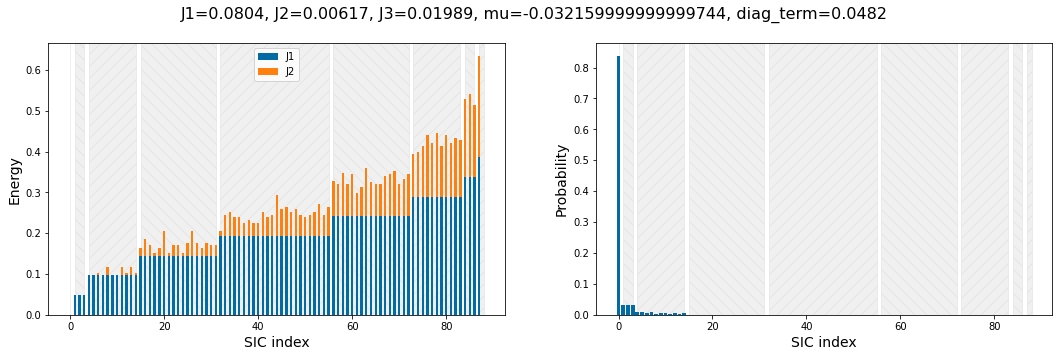

potential =-30%


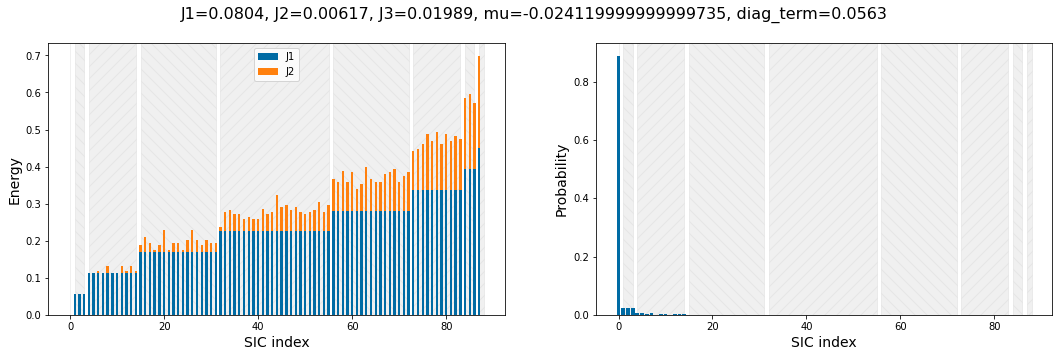

potential =-20%


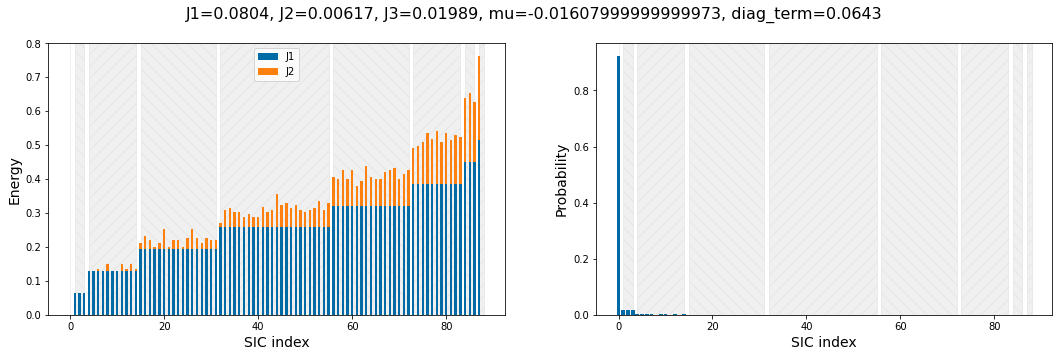

potential =-10%


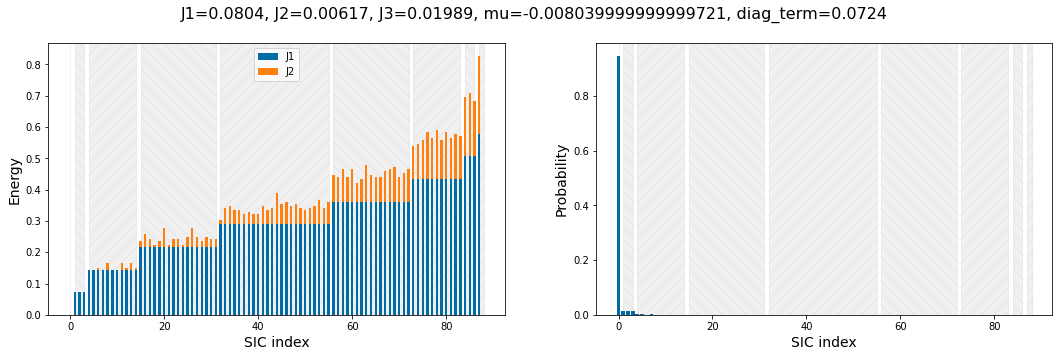

In [690]:
for potential in np.arange(-4,0,0.1):
    print('potential ={}%'.format(round(potential*100),4))
    plot_E_p_QUBO(structure,J1=0.0804,J2nn=0.00617,J2nnn=0.01989,mu=potential)

Considerations:
- by changing J1 we are changing the orange component to the graph (grand canonical ensemble)
- J1 == 0 only the J2 energy influences the partition function
- In the final calculation of Z, we need to use the original qubo
- structure 32 is an artifact

## <a id='no_pbc'> Non-periodic boundary conditions</a>

In [409]:
# Function to check if a point is inside the hexagon
def is_inside_hexagon(size,x, y):
    
    """
    Check if a point (x, y) is inside a regular hexagon of a specified size.

    This function determines whether a given point is inside or outside a regular hexagon
    with a specified size.

    Parameters:
    - size (float): The size of the hexagon (distance from the center to a vertex).
    - x (float): The x-coordinate of the point to be checked.
    - y (float): The y-coordinate of the point to be checked.

    Returns:
    - inside (bool): True if the point is inside the hexagon, False otherwise.

    """
    
    hexagon_vertices = size*np.array([(1, 0), (0.5, math.sqrt(3) / 2), (-0.5, math.sqrt(3) / 2), (-1, 0), (-0.5, -math.sqrt(3) / 2), (0.5, -math.sqrt(3) / 2)])

    odd_nodes = False
    j = len(hexagon_vertices) - 1

    for i in range(len(hexagon_vertices)):
        xi, yi = hexagon_vertices[i]
        xj, yj = hexagon_vertices[j]

        if yi < y and yj >= y or yj < y and yi >= y:
            if xi + (y - yi) / (yj - yi) * (xj - xi) < x:
                odd_nodes = not odd_nodes

        j = i

    return odd_nodes

In [414]:
def cut_graphene(structure_bulk,size,center=True):
    
    """
    Cut a graphene structure to a specified size using a hexagonal mask.

    This function takes a bulk graphene structure and creates a smaller graphene structure
    by applying a hexagonal mask with the specified size. The resulting structure is a
    smaller graphene sheet centered on the original structure.

    Parameters:
    - structure_bulk (Structure): The bulk graphene structure to be cut.
    - size (float): The size of the hexagonal mask used for cutting.

    Returns:
    - Molecule: A smaller graphene structure after applying the hexagonal mask.

    """
    
    structure = copy.deepcopy(structure_bulk)
    
    expansion_matrix = 2*np.eye(3)
    expansion_matrix[2][2] = 1
    structure.make_supercell(expansion_matrix)
    if center == True:
        com = np.mean(structure.frac_coords,axis=0)
        structure.translate_sites(np.arange(structure.num_sites),-com,to_unit_cell=False)
    
    expansion_matrix = 7*np.eye(3)
    expansion_matrix[2][2] = 1
    structure.make_supercell(expansion_matrix)
    if center == True:
        com = np.mean(structure.frac_coords,axis=0)
        structure.translate_sites(np.arange(structure.num_sites),-com,to_unit_cell=False)

    mask = []
    for i in range(structure.num_sites):
        x = structure.cart_coords[i][0]
        y = structure.cart_coords[i][1]
        mask.append(is_inside_hexagon(size,x, y))
        
    keep_site = np.where(np.array(mask) == True)
    
    species = np.array(structure.atomic_numbers)[keep_site]
    coordinates = np.array(structure.cart_coords)[keep_site]
    return Molecule(species,coordinates)

In [457]:
graphene_mol = cut_graphene(graphene,size=10,center=False)
print(graphene_mol.num_sites)
vview(graphene_mol)

32


In [169]:
graphene_mol_no_h = cut_graphene(graphene,size=15)
print(graphene_mol_no_h.num_sites)
#vview(graphene_mol_no_h)

216


#### Replace the external C atoms with H atoms

In [258]:
def build_adjacency_matrix(structure, max_neigh = 1, diagonal_terms = False, triu = False):
    # structure = pymatgen Structure object
    
    num_sites = structure.num_sites
    distance_matrix_pbc = np.round(structure.distance_matrix,5)

    distance_matrix = np.zeros((num_sites,num_sites),float)
    
    shells = np.unique(distance_matrix_pbc[0])
    
    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix_pbc == s)[0]
        col_index = np.where(distance_matrix_pbc == s)[1]
        distance_matrix[row_index,col_index] = i
    
    if triu == True:
        distance_matrix = np.triu(distance_matrix,0)
    
    if diagonal_terms == True:
        np.fill_diagonal(distance_matrix,[1]*num_sites)
    
    return distance_matrix

In [185]:
adj_matrix = build_adjacency_matrix(graphene_mol, max_neigh = 1)
h_atom_sites = np.where(np.unique(np.where(adj_matrix==1)[0],return_counts=True)[1]==1)[0]
atom_numbers = np.array(graphene_mol.atomic_numbers)
atom_numbers[h_atom_sites] = 1
graphene_mol_h = Molecule(atom_numbers,graphene_mol.cart_coords)
graphene_mol_h_96 = copy.deepcopy(graphene_mol_h)

In [184]:
vview(graphene_mol_h)

#### Write the structure to a gui file

In [178]:
graphene_mol_h_gui = cry_pmg2gui(graphene_mol_h,pbc=[False, False, False],symmetry=True)
graphene_mol_h_gui.write_gui('./data/crystal/graphene/graphene_252_h_36.gui',symm=True)

Avogadro optimisation

In [547]:
from pymatgen.io.xyz import XYZ
#XYZ(graphene_mol_h).write_file('./data/crystal/graphene/graphene_96_h_24.xyz')
xyz_file = XYZ.from_file('./data/crystal/graphene/graphene_96_h_24.xyz')
graphene_mol_h_gui = cry_pmg2gui(xyz_file.molecule,pbc=[False, False, False],symmetry=True)
graphene_mol_h_gui.write_gui('./data/crystal/graphene/graphene_96_h_24.gui')

## <a id='test_train'>Build the test/train set</a>
- at least one structure per equivalent atom
- all the 2dopants nn subset
- then random

In [337]:
graphene_mol_h_96_opt = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/graphene_96_h_24.gui'))
graphene_mol_h_96_opt = Molecule(graphene_mol_h_96_opt.atomic_numbers,graphene_mol_h_96_opt.cart_coords)

In [339]:
atom_indices_96 = get_all_configurations_no_pbc(graphene_mol_h_96_opt)

First generate all the SICs with 1 dopant atoms

In [340]:
def generate_1_doped_structures(molecule,dopant,active_species=None):
    
    molecules_1_dopant = []
    
    ineq_atoms = PointGroupAnalyzer(molecule).get_equivalent_atoms()['eq_sets'].keys()
    ineq_atoms = [x for x in ineq_atoms]
    
    # C only
    if active_species is not None:
        C_atom_index = np.where(np.array(molecule.atomic_numbers) == active_species)
        ineq_atoms = np.intersect1d(ineq_atoms,C_atom_index)
    
    for site in ineq_atoms:
        molecule_tmp = copy.deepcopy(molecule)
        atomic_numbers = np.array(molecule_tmp.atomic_numbers)
        atomic_numbers[site] = dopant
        coordinates = molecule_tmp.cart_coords
        molecules_1_dopant.append(Molecule(atomic_numbers,coordinates))
        
    return molecules_1_dopant
molecules_1_dopant = generate_1_doped_structures(graphene_mol_h_96,7,active_species=6)  

First generate all the SICs with 2 adjacent dopant atoms

In [341]:
def generate_2_doped_structures(molecules_1_dopant,dopant,active_species=None):
    
    molecules_2_dopant = []
    
    
    
    for molecule in molecules_1_dopant:
        
        if active_species is not None:
            C_atom_index = np.where(np.array(molecules_1_dopant[0].atomic_numbers) == active_species)
        else:
            C_atom_index = np.arange(molecules_1_dopant[0].num_sites)
        ineq_atoms_nn = np.array(molecule.atomic_numbers)
        dopant_site = np.where(ineq_atoms_nn==dopant)[0][0]
        
        all_nn = np.argsort(molecule.distance_matrix[dopant_site] )[1:4]
        nn_index = np.intersect1d(all_nn,C_atom_index)
        #print(dopant_site,nn_index)
        
        for site in nn_index:

            molecule_tmp = copy.deepcopy(molecule)
            atomic_numbers = np.array(molecule_tmp.atomic_numbers)
            atomic_numbers[site] = dopant
            coordinates = molecule_tmp.cart_coords
            molecules_2_dopant.append(Molecule(atomic_numbers,coordinates))
    return molecules_2_dopant
#     # C only
#     if active_species is not None:
#         C_atom_index = np.where(np.array(molecule.atomic_numbers) == active_species)
#         ineq_atoms = np.intersect1d(ineq_atoms,C_atom_index)
    

#     return molecules_1_dopant
molecules_2_dopant = generate_2_doped_structures(molecules_1_dopant[0:10],7,active_species=6)  

First generate the SIC randomly. For 2 dopant atoms, we can provide the list of adjacent SIC via config_unique.

In [360]:
def generate_random_structures(initial_molecule,atom_indices,N_atoms,new_species,
                               N_config,DFT_config,active_sites=False,return_multiplicity=False,
                              config_unique=[]):
    
    """
    Generate random symmetry-independent structures by replacing sites in the initial molecule.

    Args:
        initial_molecule (Molecule): The initial molecule structure.
        atom_indices (list): Indices obtained from get_all_configurations.
        N_atoms (int): Number of sites to replace.
        new_species (int): New atomic number.
        N_config (int): Number of attempts.
        DFT_config (int): Number of final structures generated.
        active_sites (list or bool, optional): Sites in the structure to replace (useful for Al/GaN). 
                                               Default is False.
        return_multiplicity (bool, optional): If True, returns the multiplicity of each unique structure. 
                                              Default is False.
        config_unique (list): the initial list of configurations. 
                              Useful for the 2 dopants where the user already has the adjacent structures.
        
    Returns:
        list of Molecule: List of symmetry-independent structures.

    """

    all_structures = []

    
    if active_sites is False:
        num_sites = initial_molecule.num_sites
        active_sites = np.arange(num_sites)
    else:
        num_sites = len(active_sites)
        
    

    # Generate a random configurations
    descriptor_all = []
    structures_all = []
    config_all = []
    config_unique = []
    config_unique_count = []
    n_sic = 0
    N_attempts= 0
    
    while n_sic < DFT_config and N_attempts <N_config:
        N_attempts += 1
        sites_index = np.random.choice(num_sites,N_atoms,replace=False)

        sites = active_sites[sites_index]
        #print(np.array(initial_molecule.atomic_numbers)[sites])
        structure_tmp = copy.deepcopy(initial_molecule)

        sec = build_symmetry_equivalent_configurations(atom_indices,sites)

        sic = sec[0]
        #print(np.array(initial_molecule.atomic_numbers)[np.where(sic==1)[0]])
        is_in_config_unique = any(np.array_equal(sic, existing_sic) for existing_sic in config_unique)

        if not is_in_config_unique:  
            config_unique.append(sic)

            config_unique_count.append(len(sec))
            n_sic += 1


    final_structures = []
    for config in config_unique:
        
        N_index = np.where(config==1)[0]
        #print(np.array(initial_molecule.atomic_numbers)[N_index])
        atomic_numbers = np.array(initial_molecule.atomic_numbers)
        #print(atomic_numbers[N_index])
        atomic_numbers[N_index] = new_species
        coordinates = initial_molecule.cart_coords
        
        final_structures.append(Molecule(atomic_numbers,coordinates))
    if return_multiplicity == True:
        return final_structures,config_unique_count
    else:
        return final_structures



### Write structures to file

One dopant atom

In [372]:
for i,struct in enumerate(molecules_1_dopant):
    struct_gui = cry_pmg2gui(struct,pbc=[False, False, False])
    struct_gui.write_gui('data/crystal/graphene/N/graphene_96_h_24_n_1_%s.gui'%i)
    sh.copy('data/crystal/graphene/graphene_96_h_24.d12','data/crystal/graphene/N/graphene_96_h_24_n_1_%s.d12'%i)
    print('timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_%s &'%i)

timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_0 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_1 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_2 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_3 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_4 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_5 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_6 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_7 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_8 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_9 &


Two adjacent dopant atoms

In [371]:
for i,struct in enumerate(molecules_2_dopant):
    struct_gui = cry_pmg2gui(struct,pbc=[False, False, False])
    struct_gui.write_gui('data/crystal/graphene/N/graphene_96_h_24_n_2_%s.gui'%i)
    sh.copy('data/crystal/graphene/graphene_96_h_24.d12','data/crystal/graphene/N/graphene_96_h_24_n_2_%s.d12'%i)
    print('timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_%s &'%i)

timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_0 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_1 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_2 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_3 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_4 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_5 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_6 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_7 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_8 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_9 &
timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_10 &
timeout 1437m /work/

Random structures

In [368]:
for n,i in enumerate(range(2,11,1)):
    N_atoms = i
    print(i)
    structures_random = generate_random_structures(graphene_mol_h_96,atom_indices=atom_indices_96,N_atoms=N_atoms,
                                         new_species=7,N_config=500,DFT_config=20,
                                         active_sites=active_sites,return_multiplicity=False,
                                         config_unique=molecules_2_dopant)
    num_structures = len(structures_random)
    train_folder = './data/crystal/graphene/N/train_set/'
    test_folder = './data/crystal/graphene/N/test_set/'
    for m,structure in enumerate(structures_random[0:int(np.ceil(num_structures/2))]):
        
        gui_object = cry_pmg2gui(structure,pbc=[False,False,False],symmetry=True)
        gui_name = 'graphene_96_h_24_n_%s_%s.gui'%(N_atoms,m)
        #gui_object.write_gui(train_folder+gui_name,symm=True)
        sh.copy('data/crystal/graphene/graphene_96_h_24.d12','data/crystal/graphene/N/train_set/graphene_96_h_24_n_%s_%s.gui'%(N_atoms,m))
    for m,structure in enumerate(structures_random[int(np.ceil(num_structures/2)):]):
        gui_object = cry_pmg2gui(structure,pbc=[False,False,False],symmetry=True)
        gui_name = 'graphene_96_h_24_n_%s_%s.gui'%(N_atoms,m)
        #gui_object.write_gui(test_folder+gui_name,symm=True)
        sh.copy('data/crystal/graphene/graphene_96_h_24.d12','data/crystal/graphene/N/test_set/graphene_96_h_24_n_%s_%s.gui'%(N_atoms,m))

2
3
4
5
6
7
8
9
10


In [355]:
generate_random_structures(graphene_mol_h_96,atom_indices=atom_indices_96,N_atoms=N_atoms,
                                         new_species=7,N_config=1000,DFT_config=20,
                                         active_sites=active_sites,return_multiplicity=True)[1]

[12, 12, 12, 12, 6, 12, 12, 12, 6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]

In [328]:
active_sites = np.where(np.array(graphene_mol_h_96.atomic_numbers) == 6)[0]
struct,mult = generate_random_structures(graphene_mol_h_96,atom_indices=atom_indices_96,N_atoms=3,
                                         new_species=7,N_config=500,DFT_config=10,
                                         active_sites=active_sites,return_multiplicity=True)

In [329]:
for structure in struct:
    vview(structure)

In [342]:
len(molecules_2_dopant)

28

# THE END

## <a id='pbc'>Periodic boundary conditions</a>

### Build QUBO from pbc calculations

In [ ]:
def build_ml_qubo(structure,X_train,y_train,max_neigh=1):
    
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    np.fill_diagonal(distance_matrix_filter,[1]*num_sites)
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0)
    descriptor = []

    for config in X_train:
        matrix = np.outer(config,config)
        upper_tri_elements = matrix[upper_tri_indices]
        descriptor.append(upper_tri_elements)
        

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    print('R2: ',reg.score(descriptor, y_train))

    Q = np.zeros((num_sites,num_sites))
    Q[upper_tri_indices] = reg.coef_
    
    return Q
    
build_ml_qubo(structure,X_train,y_train,max_neigh=1)
X_train

### Build H$_{\text{ryd}}$ from pbc calculations

In [ ]:
def build_ml_h_ryd(structure,X_train,y_train,max_neigh=1):
    
    C = 5.42e-24
    
    
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    np.fill_diagonal(distance_matrix_filter,[1]*num_sites)
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0)
    descriptor = []

    for config in X_train:
        matrix = np.outer(config,config)
        upper_tri_elements = matrix[upper_tri_indices]
        descriptor.append(upper_tri_elements)
        

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    print('R2: ',reg.score(descriptor, y_train))

    Q = np.zeros((num_sites,num_sites))
    Q[upper_tri_indices] = reg.coef_
    
    return Q
    
build_ml_qubo(structure,X_train,y_train,max_neigh=1)
X_train

### Auxiliary qubits method

#### Build the structure

In [242]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 3
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
# ordering = [1,5,0,3,4,7,2,6]
# graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
#                            graphene_scell.frac_coords[ordering])
graphene_scell.remove_sites([0,1,2,5,8,11])
ordering = [1,7,0,3,6,10,2,9,5,8,4,11]
# graphene_scell_au = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
#                            graphene_scell.frac_coords[ordering])
graphene_scell_au = Molecule(graphene_scell.atomic_numbers,
                           graphene_scell.cart_coords[ordering])

- 10 -> 7
- 8 -> 5
- 9 -> 4
- 11 -> 7

In [251]:
vview(graphene_scell_au)

In [244]:
def classical_energy(x,q):
    # x is the binary vector
    # q is the qubo matrix

    E_tmp = np.matmul(x,q)
    E_classical = np.sum(x*E_tmp)
    
    return E_classical

In [577]:
def J1_energy(x,q):
    # x is the binary vector
    # q is the qubo matrix
    
    return np.sum(q.diagonal()*x)

In [576]:
def J2_energy(x,q):
    # x is the binary vector
    # q is the qubo matrix
    q = np.triu(q,1)
    E_tmp = np.matmul(x,q)
    E_classical = np.sum(x*E_tmp)
    
    return E_classical

In [398]:
Q = -build_adjacency_matrix(graphene_scell_au,triu=True)
# for i in range(graphene_scell_au.num_sites-4):
#     Q[i][i] = 3
# for i in range(graphene_scell_au.num_sites):
#     Q[i][i] = 3
diag = np.array([3,3,3,3,1.5,1.5,3,1,1.5,1.5,1,1])

np.fill_diagonal(Q,diag)
configurations = np.array(list(itertools.product([0, 1], repeat=graphene_scell_au.num_sites)))

all_energy = []

for config in configurations:
    all_energy.append(classical_energy(config,Q))

In [402]:
np.argsort(all_energy)

array([   0,    1,    2, ..., 3901, 2878, 3884])

In [278]:
acceptable_configurations = []
acceptable_energies = []
acceptable_index = []
non_acceptable_configurations = []
non_acceptable_energies = []
for i,config in enumerate(configurations):
    if np.all(config[[10,8,9,11]] == config[[7,5,4,7]]):
        acceptable_configurations.append(config)
        acceptable_energies.append(all_energy[i])
        acceptable_index.append(i)
    else:
        non_acceptable_configurations.append(config)
        non_acceptable_energies.append(all_energy[i])

### Energy

In [400]:
# 2 adjacent vacancies
x = np.zeros(graphene_scell_au.num_sites)
x[1] = 1
x[2] = 1

print(classical_energy(x,Q))

x = np.zeros(graphene_scell_au.num_sites)
x[2] = 1
x[7] = 1
x[10] = 1
x[11] = 1

print(classical_energy(x,Q))

5.0
5.0


In [271]:
def get_partition_function(energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.):
    """
    Calculate the partition function and probabilities for different energy levels.
    
    Args:
        energy (np.ndarray): Array of energy levels.
        multiplicity (np.ndarray): Array of corresponding multiplicities.
        T (float, optional): Temperature in Kelvin. Default is 298.15 K.
        return_pi (bool, optional): Flag to return probabilities. Default is True.
        N_N (float, optional): Number of N particles. Default is 0.
        N_potential (float, optional): Potential for N particles. Default is 0.

    Returns:
        tuple or float: If return_pi is True, returns a tuple containing partition function and probabilities.
                        Otherwise, returns the partition function.
    """
    k_b = 8.617333262145e-05  # Boltzmann constant in eV/K
    
    energy = np.array(energy)
    multiplicity = np.array(multiplicity)
    p_i = multiplicity * np.exp((-energy + (N_N * N_potential)) / (k_b * T))
    pf = np.sum(p_i)
    
    p_i /= pf
    
    if return_pi:
        return pf, p_i
    else:
        return pf

In [330]:
multiplicity = np.ones(len(all_energy))
Z,pi = get_partition_function(all_energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)

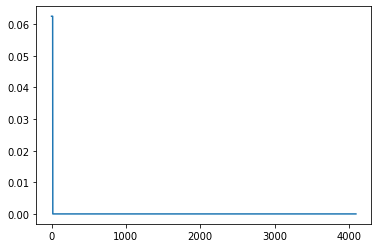

In [331]:
plt.plot(np.arange(len(pi)),pi)

### Fixed composition

#### Acceptable + non acceptable

In [284]:
configurations[two_vac_index][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [302]:
four_vac_index = np.where(np.sum(configurations,axis=1)==4)[0]

In [248]:
three_vac_index = np.where(np.sum(configurations,axis=1)==3)[0]

In [269]:
two_vac_index = np.where(np.sum(configurations,axis=1)==2)[0]

In [307]:
two_three_vac_index = np.sort(np.append(two_vac_index,three_vac_index))
two_three_four_vac_index = np.sort(np.append(two_three_vac_index,four_vac_index))

In [403]:
energies = 0.01*np.array(all_energy)[two_three_four_vac_index]
multiplicity = np.ones(len(energies))
Z,pi = get_partition_function(energies, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)

In [405]:
np.argsort(pi)

array([722, 357, 358, 777, 721, 547, 660, 696, 768, 524, 723, 698, 523,
       487, 486, 719, 720, 699, 707, 724, 661, 662, 677, 348, 189, 658,
       718, 485, 659, 717, 742, 743, 410, 716, 700, 663, 780, 697, 354,
       355, 356, 359, 281, 695, 521, 405, 185, 188, 352, 353, 373, 279,
       676, 706, 276, 670, 366, 409, 408, 406, 673, 702, 714, 532, 745,
       778, 760, 770, 545, 544, 753, 744, 502, 520, 514, 767, 236, 371,
       307, 403, 237, 370, 364, 522, 764, 704, 363, 525, 529, 530, 546,
       674, 678, 761, 675, 691, 705, 306, 746, 458, 457, 436, 435, 776,
       477, 578, 500, 484, 655, 741, 772, 483, 488, 499, 715, 648, 549,
       186, 187, 235, 304, 297, 630, 227, 286, 631, 285, 581, 275, 580,
       193, 280, 584, 194, 277, 278, 651, 548, 463, 527, 343, 184, 495,
       414, 415, 608, 426, 433, 482, 481, 434, 476, 473, 448, 455, 456,
       498, 342, 407, 501, 344, 345, 346, 347, 539, 531, 464, 365, 372,
       519, 518, 512, 509, 779, 609, 404, 183, 583, 766, 693, 68

In [406]:
configurations[two_three_four_vac_index][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [384]:
three_vac_index_2 = np.where(np.sum(configurations[acceptable_index],axis=1)==3)[0]

In [281]:
np.intersect1d(three_vac_index, acceptable_index)

array([  19,  104,  164,  328,  388,  584,  644,  800, 1096, 1156, 1312,
       1568, 1792, 2120, 2180, 2336, 2592, 2816, 3104, 3328, 3584])

In [276]:
indeces = np.where(np.isin(three_vac_index, acceptable_index))[0]

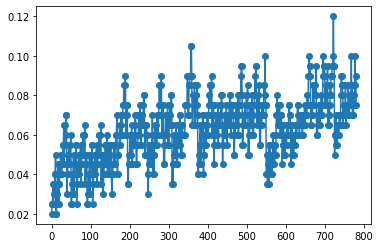

In [319]:
plt.plot(np.arange(len(energies)),energies,'-o')
#plt.plot(np.arange(len(energies))[indeces],energies[indeces],'o')

In [320]:
np.sort(energies)

array([0.02 , 0.02 , 0.02 , 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.03 , 0.03 , 0.03 ,
       0.03 , 0.03 , 0.03 , 0.03 , 0.03 , 0.03 , 0.03 , 0.035, 0.035,
       0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035,
       0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035,
       0.035, 0.035, 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 ,
       0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 ,
       0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 ,
       0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.04 ,
       0.04 , 0.04 , 0.04 , 0.04 , 0.04 , 0.045, 0.045, 0.045, 0.045,
       0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045,
       0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045,
       0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045,
       0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045,
       0.045, 0.045,

In [321]:
np.argsort(energies)

array([  0,  12,  11, 105,  50,  51,  92,  18,  14,  91,   5,  64,   1,
         4,   2,  94,  98, 154, 132,  53,  57,  13,   7,  39, 247, 106,
       107, 553,  75,  52,  93,  86,  66,  65, 557, 116, 309, 311,   3,
         6, 195, 127, 196,  19,  20,  15,  16, 155, 112, 376, 156, 389,
       375, 168, 153, 143, 246, 248, 134,  95,  96, 133,  99, 100, 260,
       262,  71, 109, 148, 550, 169,  68, 551, 564,  40,  41, 561,  55,
        58,  59,  26,  25,  54,   8,   9,  22, 206, 568, 571, 289, 287,
       197, 198,  32, 128, 129, 591, 255,  28, 253, 136, 251, 249, 139,
       118, 161, 613, 158, 157,  17,  21, 218, 217, 207, 162, 117, 310,
       312,  67,  76,  77, 438, 416, 382,  61, 554,  87,  88, 555, 558,
       559,  46,  43, 378, 108, 102, 322, 320, 595, 725, 316, 467, 200,
       199, 315, 318, 313, 468, 504, 506, 171, 565, 391, 203, 202, 598,
       263, 620, 377, 574, 239, 240, 566, 261, 563, 331, 333, 562, 552,
       617, 390,  70, 131,  73,  97,  60, 130, 123,  69, 150, 14

In [322]:
np.where(configurations[two_three_four_vac_index][0]==1)[0]

array([10, 11])

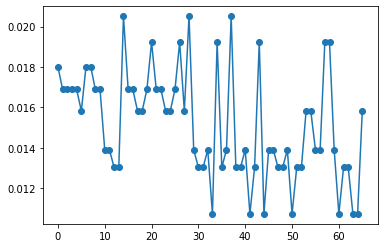

In [292]:
plt.plot(np.arange(len(pi)),pi,'-o')
#plt.plot(np.arange(len(pi))[indeces],pi[indeces],'o')

#### Acceptable only

In [406]:
a = np.array(acceptable_index)[three_vac_index_acc]

In [401]:
three_vac_index_acc = np.where(np.sum(acceptable_configurations,axis=1)==3)[0]

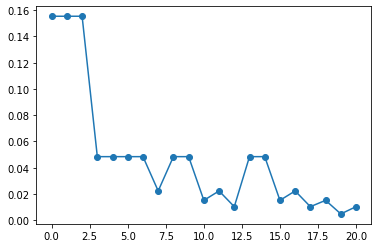

In [363]:
energies = 0.01*np.array(all_energy)[three_vac_index_acc]
multiplicity = np.ones(len(energies))
Z,pi = get_partition_function(energies, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
plt.plot(np.arange(len(pi)),pi,'-o')